# **Project Description: Evaluating KANs for Interpretable Medical Predictions**

Objective: This project aims to explore the architecture of Kolmogorov-Arnold Networks (KANs) as an alternative to traditional Multi-Layer Perceptrons (MLPs). Specifically, the study will investigate how replacing fixed activation functions with learnable splines affects model accuracy and interpretability (Liu et al., 2024).

Scope: Inspired by recent research into non-invasive diagnostics, the project will implement a KAN to predict health risks—such as dementia—using physiological markers like Heart Rate Variability (HRV) and physical performance metrics (Ali, 2025). The goal is to demonstrate that "pruning" a KAN can lead to a highly transparent model that maintains high predictive performance even with a reduced, non-invasive feature set.

In [1]:
import pandas as pd

df = pd.read_csv('agricultural_data_full.csv')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the target variable
target = 'LP_Mainfield(in Tonnes)'

# Create X (features) and y (target) for the Full dataset
X_full = df.drop(columns=[target])
y_full = df[target]

# Create X and y for the Reduced dataset
X_reduced = df.drop(columns=[target])
y_reduced = df[target]

In [4]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_train_f_scaled = scaler.fit_transform(X_train_f)
X_test_f_scaled = scaler.transform(X_test_f)

In [8]:
#!pip install pykan
#!pip install torch

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.9.1-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached torch-2.9.1-cp311-cp311-win_amd64.whl (111.0 MB)
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)

   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3 [mpmath]
   ---------------------------------------- 0/3

In [9]:
from kan import KAN
import torch

def build_kan_regression(input_dim):
    # width=[inputs, hidden_neurons, outputs]
    # grid=5 is a good starting point for simplicity
    model = KAN(width=[input_dim, 5, 1], grid=5, k=3)
    return model

In [14]:
import torch

# 1. Convert training data to float32 Tensors
train_input = torch.from_numpy(X_train_f_scaled).float()
train_label = torch.tensor(y_train_f.values).float().reshape(-1, 1)

# 2. Convert test data to float32 Tensors
test_input = torch.from_numpy(X_test_f_scaled).float()
test_label = torch.tensor(y_test_f.values).float().reshape(-1, 1)

# 3. Create the required dataset dictionary
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

In [16]:
input_dim = X_train_f_scaled.shape[1]
model_kan = build_kan_regression(input_dim)

# Assuming model_kan is already initialized
# We use .fit() instead of .train() for pykan models
results = model_kan.fit(
    dataset, 
    opt="LBFGS", 
    steps=20, 
    loss_fn=torch.nn.MSELoss()
)

# After fitting, we can check the loss history
print(f"Final Train Loss: {results['train_loss'][-1]}")
print(f"Final Test Loss: {results['test_loss'][-1]}")

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.25e-02 | test_loss: 1.18e-02 | reg: 1.12e+02 | : 100%|█| 20/20 [00:46<00:00,  2.34s/

saving model version 0.1
Final Train Loss: 0.012505738995969296
Final Test Loss: 0.011762789450585842


# **The Performance Table**

In [17]:
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd
import torch

# 1. Get predictions (using torch.no_grad to save memory)
with torch.no_grad():
    y_pred_kan = model_kan(dataset['test_input']).numpy()
    y_true_kan = dataset['test_label'].numpy()

# 2. Calculate the metrics
mae_kan = mean_absolute_error(y_true_kan, y_pred_kan)
r2_kan = r2_score(y_true_kan, y_pred_kan)

# 3. Display the results matrix
metrics_kan = pd.DataFrame({
    'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R-squared (R2)'],
    'Value': [f"{results['test_loss'][-1]:.4f}", f"{mae_kan:.4f}", f"{r2_kan:.4f}"]
})

print("--- KAN Performance (Reduced Dataset) ---")
print(metrics_kan.to_string(index=False))

--- KAN Performance (Reduced Dataset) ---
                   Metric  Value
 Mean Squared Error (MSE) 0.0118
Mean Absolute Error (MAE) 0.0080
           R-squared (R2) 1.0000


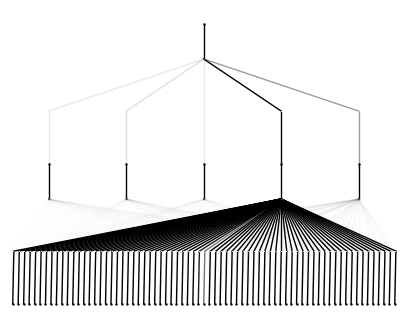

In [18]:
# Generate the interpretability plot
model_kan.plot(beta=100)

# **Uncovering the Formula**

In [19]:
# 1. Identify the mathematical functions for the most active paths
lib = ['x', 'x^2', '1/x', 'exp', 'log', 'sqrt', 'sin', 'abs']
model_kan.auto_symbolic(lib=lib)

# 2. Print the final simplified formula for LP_Mainfield
formula = model_kan.symbolic_formula()[0][0]
print(f"The discovered yield formula is: {formula}")

fixing (0,0,0) with x^2, r2=0.9990462064743042, c=2
fixing (0,0,1) with x^2, r2=0.9995962977409363, c=2
fixing (0,0,2) with x^2, r2=0.9991626739501953, c=2
fixing (0,0,3) with x, r2=0.9960489273071289, c=1
fixing (0,0,4) with x^2, r2=0.9990499019622803, c=2
fixing (0,1,0) with x^2, r2=0.9990288019180298, c=2
fixing (0,1,1) with x^2, r2=0.9995471239089966, c=2
fixing (0,1,2) with x^2, r2=0.9992090463638306, c=2
fixing (0,1,3) with sin, r2=0.9999987483024597, c=2
fixing (0,1,4) with x^2, r2=0.9977347254753113, c=2
fixing (0,2,0) with x^2, r2=0.9990121126174927, c=2
fixing (0,2,1) with x^2, r2=0.9993452429771423, c=2
fixing (0,2,2) with x^2, r2=0.9990836977958679, c=2
fixing (0,2,3) with x, r2=0.9997208714485168, c=1
fixing (0,2,4) with x^2, r2=0.9986843466758728, c=2
fixing (0,3,0) with x^2, r2=0.9986539483070374, c=2
fixing (0,3,1) with x^2, r2=0.9995198249816895, c=2
fixing (0,3,2) with x^2, r2=0.998849630355835, c=2
fixing (0,3,3) with sin, r2=0.9995465278625488, c=2
fixing (0,3,4) wi

C:\Users\tumom\AppData\Roaming\Python\Python311\site-packages\sympy\core\sympify.py:475: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:837.)
  return sympify(float(a))


The discovered yield formula is: 1.71897439576375*x_1 + 1.65537399222818*x_10 + 1.69942666947099*x_3 + 0.0728420627168353*x_36 + 1.70339201168651*x_37 + 1.98776760888408*x_38 + 2.17849537986868*x_39 + 1.35345357346308*x_40 + 1.01815861944615*x_41 + 1.47103538856248*x_42 + 1.43385726122622*x_43 + 1.58610421599886*x_44 + 1.5570627790936*x_45 + 1.08253951434229*x_46 + 1.08253651391013*x_47 + 1.20870073642023*x_48 + 1.20910887126696*x_49 + 1.98278550375531*x_50 + 1.07710269181183*x_51 + 1.22633476662349*x_52 + 1.36442225368183*x_53 + 1.68161555857293*x_54 + 2.06473069747682*x_55 + 1.91882794461067*x_56 + 1.27761248179261*x_57 + 1.00821800036123*x_58 + 1.60727496570489*x_59 + 1.97260912782547*x_60 + 1.85189589817701*x_61 + 0.90890922380523*x_62 + 2.05826464116027*x_63 + 1.54800600028337*x_64 + 1.43353969613826*x_65 + 1.67675126287476*x_66 + 1.47377370402859*x_67 + 1.86837905963575*x_68 + 1.11982352451379*x_69 + 0.863739193346046*x_70 + 2.11329563019698*x_71 + 7.2007925361128e-6*(-7.91968011